In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# In this code, we will demonstrate Value iteration algorithm for a simple grid world problem
# The grid world is a 4x4 grid with 16 states. The agent can move in 4 directions: up, down, left, right
# Except for the boundary states, the agent can move in all 4 directions from any state
# The agent receives a reward of -1 for each step and the episode ends when the agent reaches the terminal state
# which is the state in the top left corner of the grid or the left right corner of the grid 
# The agent receives a reward of 0 at the terminal state
# The goal of the agent is to find the optimal policy that maximizes the expected cumulative reward

# The value iteration algorithm is an iterative algorithm that updates the value of each state based on the Bellman equation
# The Bellman equation is a recursive equation that expresses the value of a state in terms of the values of its neighboring states
# The value of a state is the expected cumulative reward that the agent can achieve from that state onwards
# The Bellman equation is given by:
# V(s) = max_a (R(s,a) + gamma * sum_s' P(s'|s,a) * V(s'))
# where V(s) is the value of state s, R(s,a) is the reward that the agent receives when it takes action a from state s
# gamma is the discount factor, P(s'|s,a) is the probability of transitioning to state s' when the agent takes action a from state s
# V(s') is the value of state s'

# The value iteration algorithm starts with an initial estimate of the value of each state and iteratively updates the value of each state
# based on the Bellman equation. The algorithm continues to update the value of each state until the values converge
# The optimal policy can be obtained from the optimal value function by selecting the action that maximizes the value of each state


In [3]:
# The grid world is a 4x4 grid with n = 16 states
# The states are numbered as follows:
# 0  1  2  3
# 4  5  6  7
# 8  9  10 11
# 12 13 14 15
S = np.arange(16) 

# The terminal states are states 0 and 15
# The agent receives a reward of 0 at the terminal state
# The agent receives a reward of -1 for each step
# The agent can move in 4 directions: up, down, left, right
# actions are represented as follows:
# top = 0
# right = 1
# down = 2
# left = 3
A = np.arange(4)

# Discount factor
gamma = 1

# The transition probabilities are represented as a 3D array where the first dimension corresponds to the state 
# the second dimension corresponds to the action and the third dimension corresponds to the next state
# the value of the transition probability P(s'|s,a) is stored in the 3D array as P[s,a,s']
                    
# create a function to calculate P of size n x m x n for a grid world of size h x w (h and w are input of the height and width of the grid)
def calculate_P(h, w):
    n = h * w
    P = np.zeros((n,4,n))
    for i in range(n):
        for j in range(4):
            if i == 0 or i == n-1:
                P[i,j,i] = 1
            else:
                if j == 0:
                    if i-w >= 0:
                        P[i,j,i-w] = 1
                    else:
                        P[i,j,i] = 1
                if j == 1:
                    if (i+1)%w != 0:
                        P[i,j,i+1] = 1
                    else:
                        P[i,j,i] = 1
                if j == 2:
                    if i+w <= n-1:
                        P[i,j,i+w] = 1
                    else:
                        P[i,j,i] = 1
                if j == 3:
                    if i%w != 0:
                        P[i,j,i-1] = 1
                    else:
                        P[i,j,i] = 1
    return P


# create a function that takes indices (i,j) where 0<=i<h and 0<=j<w as input and returns the state number
def get_state_number(i, j, h, w):
    return i*w + j 


# create a function that creates obstacles in the grid world which the agent cannot move to 
# the function takes the grid world, and indices (i,j) where 0<=i<h and 0<=j<w as input
# and updates the transition probabilities P of the grid world such that the agent cannot move to the nodes (it checks the 4 directions)
def create_obstacles(P, obstacles, h, w):
    for i in range(h):
        for j in range(w):
            if (i,j) in obstacles:
                obstacle_s = get_state_number(i, j, h, w)
                P[obstacle_s] = 0
                # using numpy if s' in P is the state of the obstacle, set P[s,a,s'] = 0 for all a and P[s,a,s] = 1
                for state in range(len(P)):
                    for action in range(len(P[state])):
                        if P[state, action, obstacle_s] == 1:
                            P[state, action, obstacle_s] = 0
                            P[state, action, state] = 1
    return P


# create a function which generates R matrix for the rewards of each state and action
# all the rewards are -1 except for the terminal states where the rewards are 0
#the function takes the grid world, and array of (i,j) - the terminal states as input
def calculate_R(P, terminal_states):
    n, m = P.shape[0], P.shape[1]
    R = np.full((n,m), -1)
    for i, j in terminal_states:
        terminal_s = get_state_number(i, j, h, w)
        R[terminal_s] = 0
    return R


# create a function to print the value function of the grid world with spaces between the values
def print_v(V, h, w):
    V_mat = np.reshape(V, (h, w))
    # Set the printing options for NumPy arrays
    np.set_printoptions(precision=2, suppress=True)
    # Print the matrix
    print(V_mat)


# create a policy pi of size n x m
# initialize the policy to equiprobable random policy
def initialize_policy(P):
    n = P.shape[0]
    m = P.shape[1]
    pi = np.full((n,m), 1/m)
    return pi


def draw_grid(h, w, obstacles, terminal_states, pi):
    grid = np.zeros((h, w, 3))  # Initialize grid with zeros (white)

    # Color obstacles as black
    for obstacle in obstacles:
        i, j = obstacle
        grid[i, j] = [1, 0, 0]  # RGB for black

    # Color terminal states as green
    for terminal_state in terminal_states:
        i, j = terminal_state
        grid[i, j] = [0, 1, 0]  # RGB for green

    # Draw the grid
    plt.imshow(grid)
    plt.title("Grid World")
    # plt.xticks(range(w))
    # plt.yticks(range(h))
    # plt.grid()
    
    
    # Add arrows based on policy
    for i in range(h):
        for j in range(w):
            if (i, j) not in obstacles:
                s = get_state_number(i, j, h, w)
                for a in range(len(A)):
                    if pi[s, a] != 0:
                        if a == 0:  # up
                            plt.arrow(j, i+0.1, 0, -0.3, head_width=0.1, head_length=0.1, fc='r', ec='r')
                        elif a == 1:  # right
                            plt.arrow(j, i, 0.3, 0, head_width=0.1, head_length=0.1, fc='r', ec='r')
                        elif a == 2:  # down
                            plt.arrow(j, i-0.1, 0, 0.3, head_width=0.1, head_length=0.1, fc='r', ec='r')
                        elif a == 3:  # left
                            plt.arrow(j, i, -0.3, 0, head_width=0.1, head_length=0.1, fc='r', ec='r')
    
    plt.show()
    

def get_MDP(h, w, obstacles, terminal_nodes):
    P = calculate_P(h, w)
    P = create_obstacles(P, obstacles, h, w)
    R = calculate_R(P, terminal_nodes)
    pi = initialize_policy(P)
    return P, R, pi


# create a value iteration function which takes the V, R, P, gamma and policy pi as input
# and returns the value function for the given policy
def one_value_iteration(V, R, P, gamma, pi):
    #initialize the new value function
    V_new = np.zeros(len(V))
    #iterate over each state
    for s in range(len(V)):
        #initialize the action value
        action_value = 0
        #iterate over each action
        for a in range(len(pi[0])):
            #calculate the action value based on the Bellman equation
            action_value += pi[s,a] * (R[s,a] + gamma * np.sum(P[s,a] * V))
        #update the value function
        V_new[s] = action_value
    return V_new


# value iteration algorithm returns the optimal value function for the given policy pi
def value_iteration(R, P, gamma, pi, epsilon, max_iter = 1000):
    #initialize the value function
    V = np.zeros(len(R))
    #initialize the change in value function
    delta = float('inf')
    #iterate until the change in value function is less than epsilon
    while delta > epsilon and max_iter > 0:
        #update the value function
        V_new = one_value_iteration(V, R, P, gamma, pi)
        #calculate the change in value function
        delta = np.max(np.abs(V_new - V))
        #update the value function
        V = V_new
        max_iter -= 1
    return V


def calculate_greedy_policy(V, R, P, gamma):
    n, m = R.shape
    new_pi = np.zeros((n,m))
    for s in range(n):
        action_values = np.zeros(m)
        for a in range(m):
            action_values[a] = R[s,a] + gamma * np.sum(P[s,a] * V)
        new_pi[s, np.argmax(action_values)] = 1
    return new_pi
        



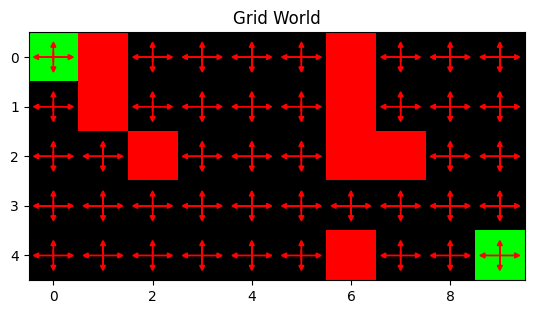

In [4]:
(h, w) = (5, 10)
terminal_states = [(0,0), (h-1, w-1)]
obstacles = [(0,1),(1,1), (2,2), (0,6), (1,6), (2,6),(2,7), (4,6)]

P, R, pi = get_MDP(h, w, obstacles, terminal_states)
draw_grid(h, w, obstacles, terminal_states, pi)

Grid World after the first policy iteration


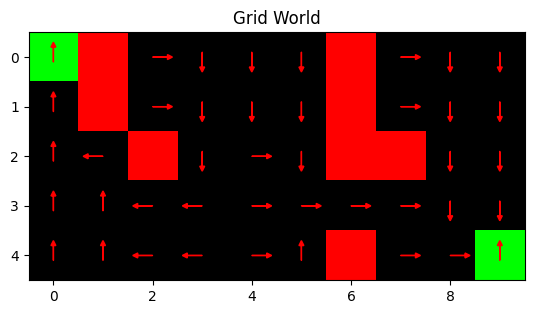

In [5]:
V = value_iteration(R, P, gamma, pi, 0.5, 10)
pi = calculate_greedy_policy(V, R, P, gamma)
print("Grid World after the first policy iteration")
draw_grid(h, w, obstacles, terminal_states, pi)

In [6]:
# create a function which implements the Policy Iteration algorithm
def policy_iteration(R, P, gamma, epsilon = 0, max_iter = 10):
    #initialize the value function
    V = np.zeros(len(R))
    #initialize the policy
    pi = initialize_policy(P)
    #initialize the change in policy
    policy_delta = float('inf')
    #iterate until the change in policy is less than epsilon
    while policy_delta > epsilon:
        #update the value function
        V = value_iteration(R, P, gamma, pi, epsilon, max_iter)
        #update the policy
        new_pi = calculate_greedy_policy(V, R, P, gamma)
        #calculate the change in policy
        policy_delta = np.max(np.abs(new_pi - pi))
        #update the policy
        pi = new_pi
    return V, pi


Value function after policy iteration


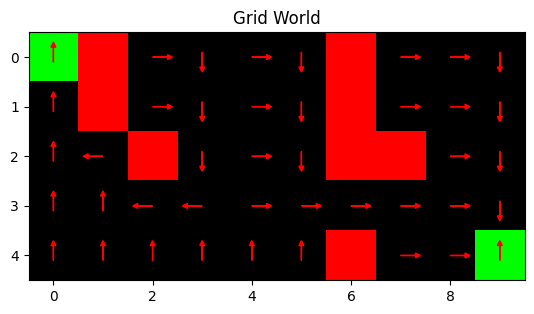

In [7]:
V, pi = policy_iteration(R, P, gamma)
print("Value function after policy iteration")
draw_grid(h, w, obstacles, terminal_states, pi)